### Clustered Calibration Example - Calibration of PTW using Three Ti-6Al-4V SHPB Stress-Strain Curves
In this script, we demonstrate the IMPALA clustered calibration methods using an example from material science. In particular, we consider three Split-Hopkinson pressure bar (SHPB) experiments for Ti-6Al-4V, where the observed data are three stress/strain curves. We calibrate these data on the Preston-Tonks-Wallace (PTW) model, which we treat as a function of 10 unknown inputs. 

#%pip install ../.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import impala.superCal.post_process as pp
from impala import superCal as sc
# import impala.superCal.impala_clust

ModuleNotFoundError: No module named 'impala_noProbit_emu'

Here, we read in the experimental data, where the first column represents plastic strain and the second column represents stress in mbar. 

In [30]:
### Read in Data for Three SHPB Experiments
dat0 = np.array([
    [0.01, 0.0100583],
    [0.02, 0.010381],
    [0.03, 0.0106112],
    [0.04, 0.0108041],
    [0.05, 0.0109619],
    [0.06, 0.011082],
    [0.07, 0.0112103],
    [0.08, 0.0113348],
    [0.09, 0.0114415],
    [0.1, 0.0115094],
])
dat1 = np.array([
    [0.01, 0.004462],
    [0.02, 0.0045834],
    [0.03, 0.0046879],
    [0.04, 0.0047613],
    [0.05, 0.004824],
    [0.06, 0.0048593],
    [0.07, 0.0049031],
    [0.08, 0.0049449],
    [0.09, 0.0049828],
    [0.1, 0.005015],
    [0.11, 0.0050471],
    [0.12, 0.0050752],
    [0.13, 0.0050964],
    [0.14, 0.0051326],
    [0.15, 0.0051495],
    [0.16, 0.0051803],
    [0.17, 0.0051816],
    [0.18, 0.0052018],
    [0.19, 0.0052262],
    [0.2, 0.0052345],
    [0.21, 0.0052651],
    [0.22, 0.0052795],
    [0.23, 0.005296],
    [0.24, 0.0053118],
    [0.25, 0.0053274],
    [0.26, 0.0053431],
    [0.27, 0.00536],
    [0.28, 0.0053702],
    [0.29, 0.0053762],
    [0.3, 0.0053926],
    [0.31, 0.00541],
    [0.32, 0.0054108],
])
dat2 = np.array([
    [0.005682, 0.0075202],
    [0.012309, 0.0077424],
    [0.020317, 0.0078811],
    [0.02867, 0.0079921],
    [0.036673, 0.0080891],
    [0.045022, 0.0081583],
    [0.05337, 0.0082275],
    [0.061718, 0.0082967],
    [0.070064, 0.008352],
    [0.078411, 0.0084074],
    [0.087102, 0.0084349],
    [0.095447, 0.0084763],
    [0.103792, 0.0085177],
    [0.112137, 0.0085591],
    [0.120482, 0.0086005],
    [0.129173, 0.008628],
    [0.137517, 0.0086555],
    [0.145862, 0.0086969],
    [0.154206, 0.0087244],
    [0.162897, 0.0087519],
    [0.173673, 0.0087794],
    [0.187578, 0.0088206],
    [0.198008, 0.0088619],
    [0.209478, 0.0088754],
    [0.217127, 0.008903],
    [0.225816, 0.0089166],
    [0.234158, 0.0089302],
    [0.243543, 0.0089438],
    [0.250844, 0.0089713],
    [0.259188, 0.0089988],
    [0.26753, 0.0090124],
    [0.276219, 0.009026],
    [0.28491, 0.0090535],
    [0.293252, 0.0090671],
    [0.301594, 0.0090807],
    [0.310284, 0.0090943],
    [0.318973, 0.0091079],
    [0.327316, 0.0091216],
    [0.336005, 0.0091352],
    [0.346434, 0.0091626],
])

# and here are the temperatures and strain rates for the three experiments:
temp0 = 573.0  # units: Kelvin
temp1 = 1373.0
temp2 = 973.0

edot0 = 800.0  # units: 1/s
edot1 = 2500.0
edot2 = 2500.0

# put the three experiments together in a list
dat_all = [dat0, dat1, dat2]
temps = [temp0, temp1, temp2]
edots = [edot0, edot1, edot2]
nexp = len(dat_all)  # number of experiments

stress_stacked = np.hstack([np.array(v)[:, 1] for v in dat_all])
strain_hist_list = [np.array(v)[:, 0] for v in dat_all]

Let's visualize the data:

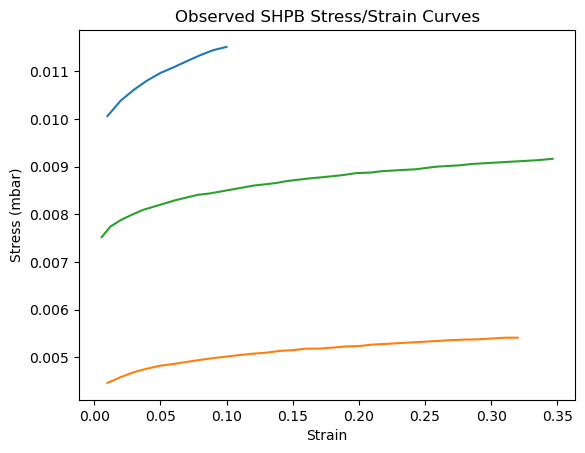

In [3]:
plt.plot(dat0[:, 0], dat0[:, 1])
plt.plot(dat1[:, 0], dat1[:, 1])
plt.plot(dat2[:, 0], dat2[:, 1])
plt.xlabel("Strain")
plt.ylabel("Stress (mbar)")
plt.title("Observed SHPB Stress/Strain Curves")
plt.show()

The Preston-Tonks-Wallace model has several fixed constants we specify for Ti-6Al-4V that are specified below. Additionally, we specify bounds for our 10 PTW input parameters we want to calibrate. PTW constraints on input parameter values are also defined. 

In [31]:
# constants fixed for PTW calibration
consts_ptw = {
    "alpha": 0.2,
    "beta": 0.33,
    "matomic": 45.9,
    "Tmelt0": 2110.0,
    "rho0": 4.419,
    "Cv0": 0.525e-5,
    "G0": 0.4,
    "chi": 1.0,
    "sgB": 6.44e-4,
}

# bounds on PTW input parameters to calibrate
bounds_ptw = {
    "theta": (0.0001, 0.2),
    "p": (0.0001, 5.0),
    "s0": (0.0001, 0.05),
    "sInf": (0.0001, 0.05),
    "kappa": (0.0001, 0.5),
    "lgamma": (-14.0, -9.0),
    "y0": (0.0001, 0.05),
    "yInf": (0.0001, 0.01),
    "y1": (0.001, 0.1),
    "y2": (0.33, 1.0),
}


# constraints: sInf < s0, yInf < y0, y0 < s0, yInf < sInf, s0 < y1, beta < y2 (but beta is fixed)
def constraints_ptw(x, bounds):
    good = (
        (x["sInf"] < x["s0"])
        * (x["yInf"] < x["y0"])
        * (x["y0"] < x["s0"])
        * (x["yInf"] < x["sInf"])
        * (x["s0"] < x["y1"])
    )
    for k in list(bounds.keys()):
        good = good * (x[k] < bounds[k][1]) * (x[k] > bounds[k][0])
    return good

Now, we set up to model structure. IMPALA has many options for the computer model specification, but here we call on IMPALA functions for PTW. The pool=False option indicates that we are running a hierarchical calibration analysis.

In [21]:
model_ptw = sc.ModelMaterialStrength(
    temps=np.array(temps),
    edots=np.array(edots) * 1e-6,
    consts=consts_ptw,
    strain_histories=strain_hist_list,
    flow_stress_model="PTW_Yield_Stress",
    melt_model="Constant_Melt_Temperature",
    shear_model="Simple_Shear_Modulus",
    specific_heat_model="Constant_Specific_Heat",
    density_model="Constant_Density",
    pool=False,
)

Now we are ready to set up and run our calibration. If several distinct types of experiments (e.g., SHPB and flyer plate experiments) are being used, additional experiments and models can be added to "setup" by calling **setup.addVecExperiments** multiple times.

This code runs a clustered calibration analysis with the following model structure: yobs ~ Normal( PTW(theta_e)) , s2_e ), where theta_e takes one of **nclustmax** values based on the experiment's cluster. Parameter s2_e is an experiment-specific noise parameter. Letting omega_g index **nclustmax** theta values, assume omega_g ~ DirichletProcess(G0, eta), where G0 is a Normal(theta_0, Sigma_0) distribution for some shared mean theta_0 and covariance Sigma_0 and where eta is a concentration parameter controlling the propensity for experiments to join existing clusters. Larger values of alpha are associated with less concentration of experiments into shared clusters. Here, PTW(.) indicates a PTW model evaluation. 

For additional details on this Dirichlet Process model specification, we refer interested readers to "Markov Chain Sampling Methods for Dirichlet Process Mixture Models" by Radford M Neal in the Journal of Computational and Graphical Statistics; 9(2); 2000.

In [40]:
s2_ind = np.hstack([
    [j] * len(np.array(dat_all[j])) for j in range(len(dat_all))
])  # this is a vector of length len(yobs) with values (0, 1, 2) indicating which experiment corresponds to which part of yobs.
setup = sc.CalibSetup(bounds_ptw, constraints_ptw)
setup.addVecExperiments(
    yobs=stress_stacked,  # observation vector, here all experiments stacked into a long vector
    model=model_ptw,  # model that predicts a vector. Here, this is our PTW model, but this could be replaced with an emulator.
    sd_est=np.array(
        [0.0001] * len(dat_all)
    ),  # yobs error estimate (possibly a vector of estimates for different parts of yobs vector)
    s2_df=np.array(
        [15] * len(dat_all)
    ),  # yobs error degrees of freedom (larger means more confidence in sd_est), same shape as sd_est
    s2_ind=s2_ind,
    theta_ind=s2_ind,
)
setup.setTemperatureLadder(
    1.05 ** np.arange(50), start_temper=2000
)  # temperature ladder, typically (1 + step)**np.arange(ntemps)
setup.setMCMC(
    nmcmc=10000, decor=100
)  # MCMC number of iterations, and how often to take a decorrelation step
setup.setHierPriors(
    theta0_prior_mean=np.repeat(0.5, setup.p),  # prior mean for theta_0 values
    theta0_prior_cov=np.eye(setup.p)
    * 10**2,  # prior covariances for theta_0 values
    Sigma0_prior_df=setup.p
    + 20,  # degrees of freedom for Inverse Wishart prior for Sigma_0. Generally, larger values indicate greater borrowing across experiments.
    Sigma0_prior_scale=np.eye(setup.p)
    * 0.1
    ** 2,  # scale for Inverse Wishart prior for Sigma_0. Generally, larger values indicate greater borrowing across experiments.
)
setup.setClusterPriors(
    nclustmax=nexp,  # maximum number of unique clusters allowed. Usually, this can be set equal to the number of experiments.
    eta_prior_shape=2,  # shape parameter for Gamma prior for eta, the "concentration" parameter controlling the propensity for experiments to join existing clusters
    eta_prior_rate=0.1,  # rate parameter for Gamma prior for eta, the "concentration" parameter controlling the propensity for experiments to join existing clusters
)
# from impala.superCal.impala_noProbit_emu import *
out = sc.impala_clust.calibClust(
    setup
)  # clustered calibration (takes 30+ minutes)

NameError: name 'initfunc_unif' is not defined

In terms of predicting behavior for new experiments, the distribution we are interested in is the DirichletProcess(G0,eta) distribution describing theta_e values for observed and new experiments. We generate draws from this distribution (we will call this the "parent" distribution) as follows:

In [29]:
## Organize MCMC Outputs
eta = pd.DataFrame(
    out.eta[:, 0].reshape(-1, 1), columns=["eta"]
)  # concentration parameter draws
delta_exp = [
    out.delta[0][:, 0, j] for j in range(nexp)
]  # cluster membership draws
omega_g = [
    out.theta[j][0, :, :] for j in range(len(out.theta))
]  # omega_g draws
omega_g = np.asarray(omega_g)
G0_parent = sc.chol_sample_1per_constraints(
    out.theta0[:, 0],
    out.Sigma0[:, 0],
    setup.checkConstraints,
    setup.bounds_mat,
    setup.bounds.keys(),
    setup.bounds,
)  # draws from G0
df = pd.DataFrame(G0_parent, columns=setup.bounds.keys())

### Draw from Parent Distribution
A = omega_g  # omega_g (niter x nclust x p)
B = np.zeros((
    omega_g.shape[0],
    setup.nclustmax,
))  # membership numbers (niter x nclust)
for i in range(len(delta_exp)):
    for j in range(omega_g.shape[0]):
        B[j, delta_exp[i][j]] += 1
N = B[0, :].sum()  # number of experiments
new_parent_ind = [
    np.random.choice(
        a=np.arange(0, 2),
        size=1,
        p=np.append(
            N / (np.asarray(eta)[j] + N),
            np.asarray(eta)[j] / (np.asarray(eta)[j] + N),
        ),
    )[0]
    for j in range(omega_g.shape[0])
]
theta_parent = [
    A[
        j,
        np.random.choice(
            a=np.arange(0, setup.nclustmax), size=1, p=B[j, :] / (B[j, :].sum())
        )[0],
        :,
    ]
    if new_parent_ind[j] == 0
    else np.asarray(df)[j, :]
    for j in range(omega_g.shape[0])
]
theta_parent = np.asarray(theta_parent)
theta_parent = pd.DataFrame(theta_parent, columns=setup.bounds.keys())

We can look at trace plots of the G0 distribution calibration parameters means (theta_0).  We want these to look like they converge, and choose which MCMC iterations to use accordingly. Now, usually trace plots for well-converged MCMC algorithms are meant to look like fuzzy caterilliars that are lying flat. That may not happen in the case of cluster; rather, the MCMC chain may bounce around between several discrete modes. 

Still, it is a good idea to take a look at these plots to see if you spot anything unexpected. Additionally, these diagnostics can help identify how many iterations to toss as "burn-in" (i.e., the iterations before the sampler reached a a stationary distribution).

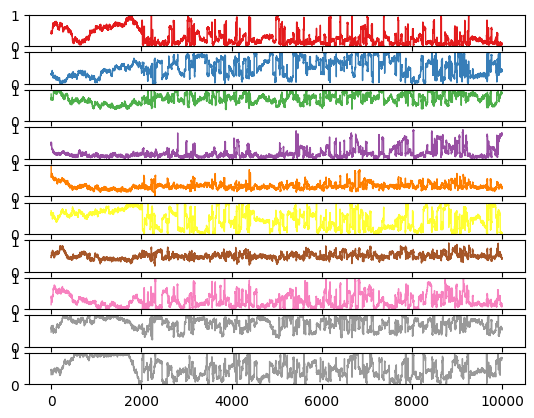

In [30]:
pp.parameter_trace_plot(out.theta0[:, 0], ylim=[0, 1])

Similarly, we can observe the convergence behavior of the parent distribution, the one we are actually interested in.

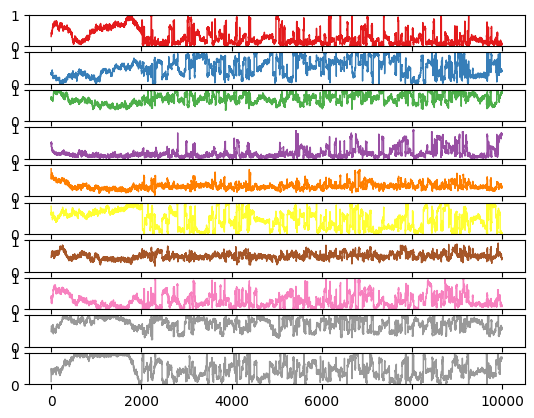

In [33]:
pp.parameter_trace_plot(np.asarray(theta_parent), ylim=[0, 1])

We disregard the first 5000 iterations and use every other iteration after that, which leaves us with 2500 iterations from our original 10000.  Here is the pairs plot of the parent posterior for theta.

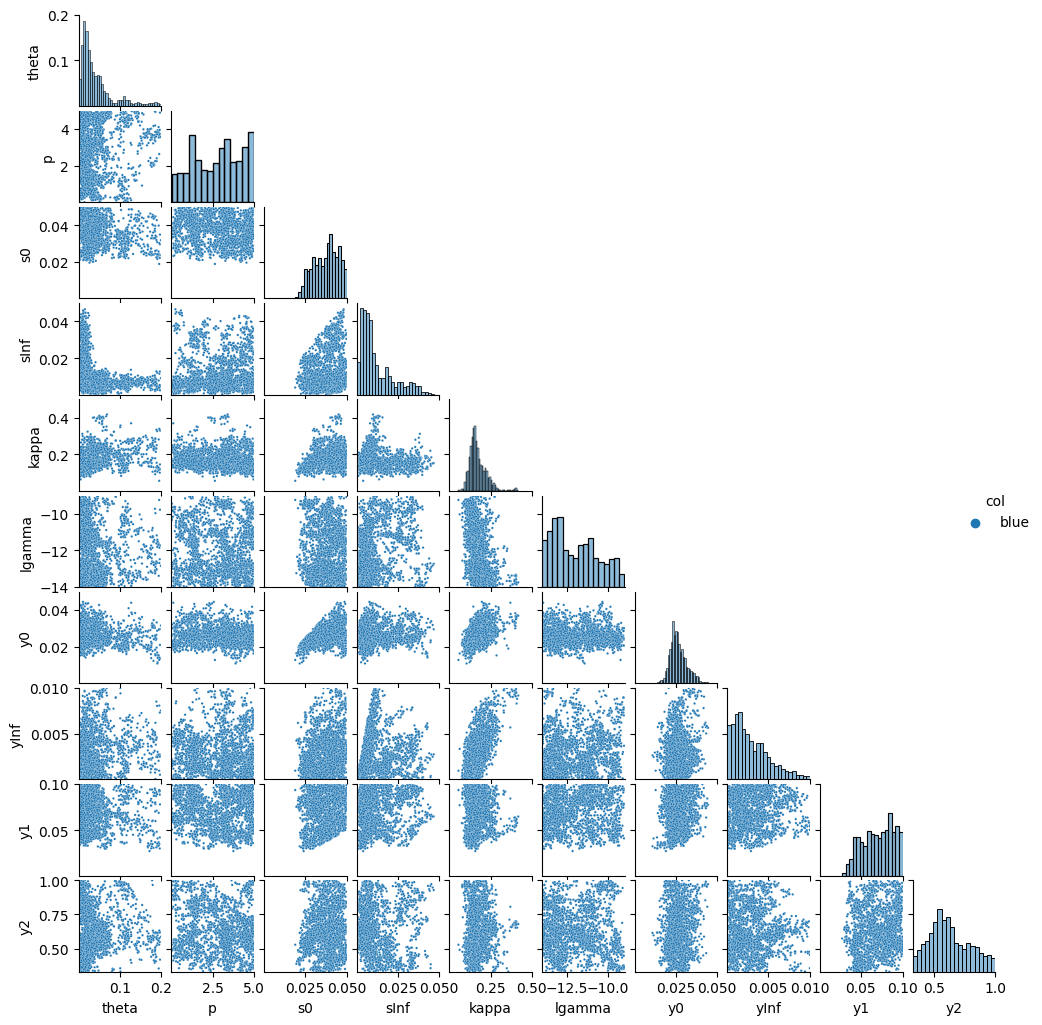

In [34]:
mcmc_use = np.arange(5000, 10000, 2)  # burn and thin index
pp.pairs(setup, np.asarray(theta_parent)[mcmc_use, :])

We also give the trace plot of the error variances (here, log-variances) for each of the three experiments. Again, we are looking for fuzzy caterpillars. 

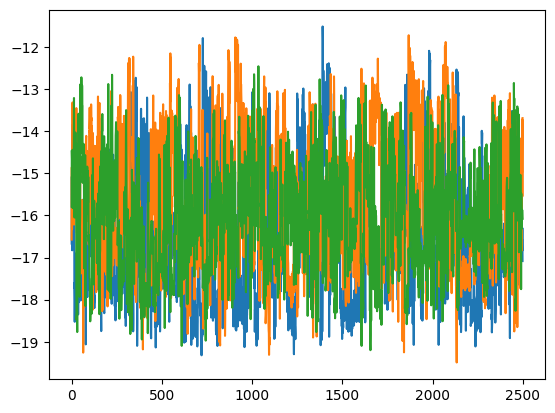

In [42]:
plt.plot(out.s2[0][mcmc_use, 0])

Let's produce our calibrated posterior predictions (with and without the observation error) with the observational data.

Text(0.5, 1.0, 'Observed and Predicted SHPB Stress/Strain Curves')

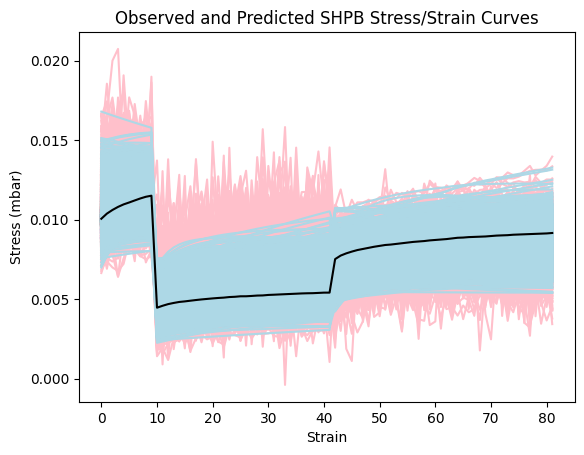

In [43]:
mat = np.asarray(theta_parent)[mcmc_use, :]
pred = setup.models[0].eval(
    sc.tran_unif(np.array(mat), setup.bounds_mat, setup.bounds.keys()),
    pool=True,
)
pred_s2 = np.random.normal(size=(len(mcmc_use), pred.shape[1])) * np.hstack([
    np.repeat(
        np.sqrt(np.exp(out.s2[0][mcmc_use, 0, i])).reshape(-1, 1),
        len(dat_all[i]),
        axis=1,
    )
    for i in range(nexp)
])
plt.plot(
    (pred + pred_s2).T, color="pink"
)  # posterior predictions including noise
plt.plot(
    pred.T, color="lightblue"
)  # posterior predictions of noiseless function
plt.plot(stress_stacked, color="black")  # observations
plt.xlabel("Strain")
plt.ylabel("Stress (mbar)")
plt.title("Observed and Predicted SHPB Stress/Strain Curves")

Now, suppose we want to obtain a single set of parameter estimates that best agree with out observed data. Several reasonable approaches exist, but here we identify the posterior draw of theta with the smallest squared prediction error.

In [44]:
pred_sse = np.sum(
    (pred - np.repeat(setup.ys[0].reshape(1, -1), len(mcmc_use), axis=0)) ** 2,
    axis=1,
)
theta_minsse = mat[np.where(pred_sse == pred_sse.min())[0][0], :]

Now, let's add the "best" predictions to the former plot. 

Text(0.5, 1.0, 'Observed and Predicted SHPB Stress/Strain Curves')

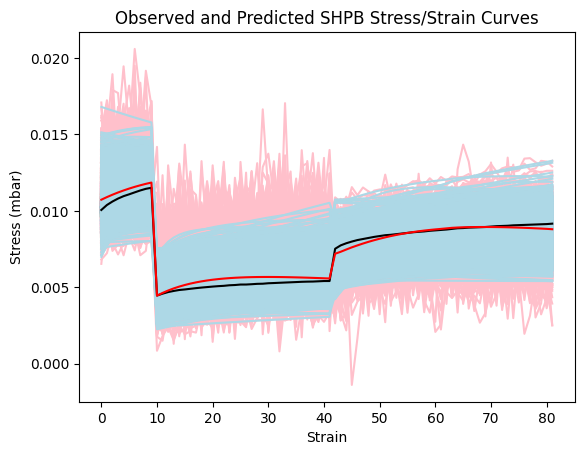

In [45]:
mat = np.asarray(theta_parent)[mcmc_use, :]
pred = setup.models[0].eval(
    sc.tran_unif(np.array(mat), setup.bounds_mat, setup.bounds.keys()),
    pool=True,
)
pred_s2 = np.random.normal(size=(len(mcmc_use), pred.shape[1])) * np.hstack([
    np.repeat(
        np.sqrt(np.exp(out.s2[0][mcmc_use, 0, i])).reshape(-1, 1),
        len(dat_all[i]),
        axis=1,
    )
    for i in range(nexp)
])
plt.plot(
    (pred + pred_s2).T, color="pink"
)  # posterior predictions including noise
plt.plot(
    pred.T, color="lightblue"
)  # posterior predictions of noiseless function
plt.plot(stress_stacked, color="black")  # observations
plt.plot(
    pred[np.where(pred_sse == pred_sse.min())[0][0], :], color="red"
)  # observations
plt.xlabel("Strain")
plt.ylabel("Stress (mbar)")
plt.title("Observed and Predicted SHPB Stress/Strain Curves")

Now, we are interested in exploring the individual theta_e values a little more closely. In particular, how similar are the individual theta_e values? 

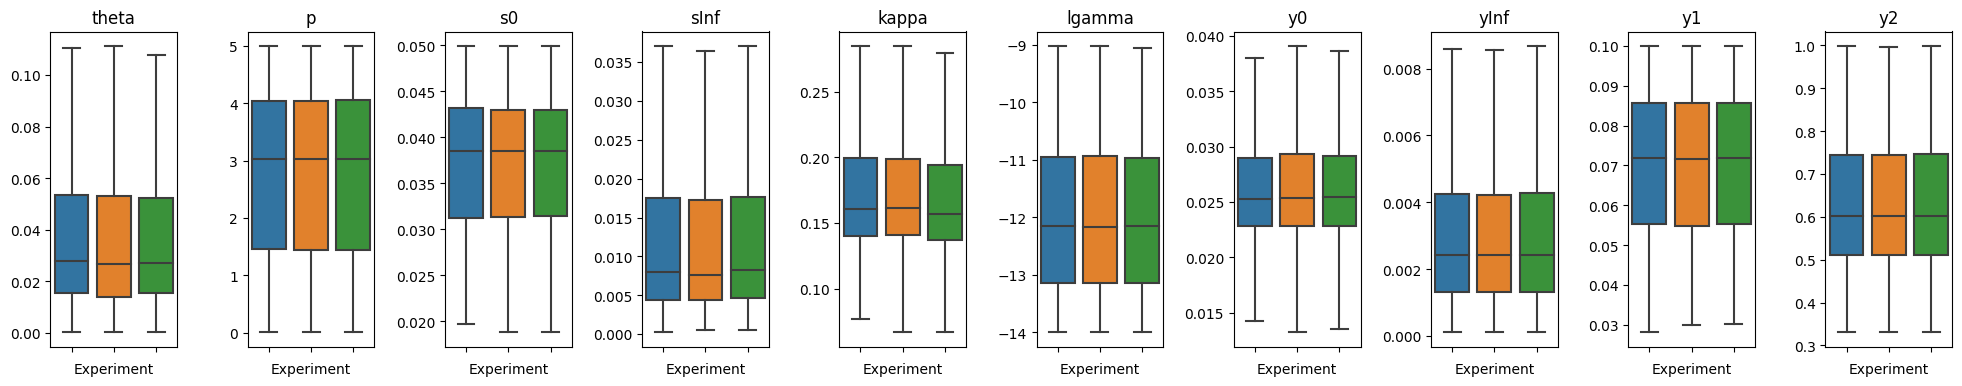

In [47]:
import seaborn as sns

theta_exp = [out.theta_hist[0][:, 0, j, :] for j in range(nexp)]

KEYS = np.array(pd.DataFrame(setup.bounds.keys())).flatten()
theta_i = []
for j in range(len(theta_exp)):
    mat = pd.DataFrame(
        np.array(
            pd.DataFrame(
                sc.tran_unif(
                    theta_exp[j][mcmc_use, :],
                    setup.bounds_mat,
                    setup.bounds.keys(),
                ).values()
            )
        ).T,
        columns=KEYS,
    )
    mat["exp"] = j
    if j == 0:
        theta_i = [mat]
    else:
        theta_i.append(mat)
theta_i_long = pd.concat(theta_i)

fig, ax = plt.subplots(1, setup.p, figsize=(20, 4))
fig.tight_layout(pad=2.0)
for j in range(setup.p):
    ax[j].set_xlabel("Experiment")
    ax[j].set_ylabel("")
    ax[j].set_title(KEYS[j])
    A = sns.boxplot(
        data=theta_i_long,
        x=theta_i_long["exp"],
        y=theta_i_long[KEYS[j]],
        ax=ax[j],
        showfliers=False,
    )
    A.set(xlabel="Experiment", ylabel="")
    A.set(xticklabels=[])

Now, we consider how different these theta_e values really are in prediction space. Does the experiment-specific theta generated for experiment 1 do a good job at predicting experiment 2? Below, we show percent error in predicting the experimental data using different pairs of experiment-specific theta and experimental data. Rows or columns that stand out indicate experiments with fundamentally different behavior, even after accounting for differences in temperature and strain rate. Note that prediction errors are very low along the diagonal, indicating that PTW is doing a good job of fitting data collected for individual experiments.

Text(0.5, 1.0, 'Prediction Errors (%)')

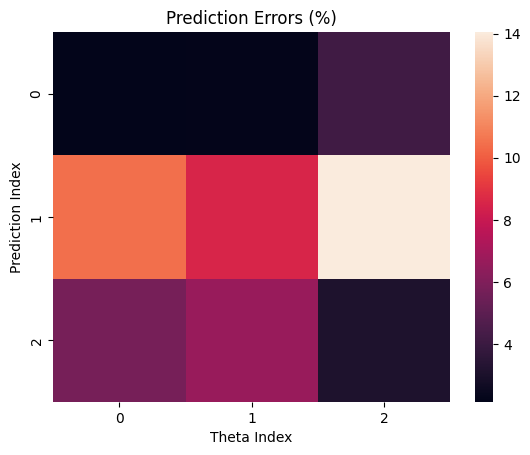

In [48]:
THETAi_Y = [
    setup.models[0].eval(
        sc.tran_unif(
            np.array(theta_exp[j][mcmc_use, :]),
            setup.bounds_mat,
            setup.bounds.keys(),
        ),
        pool=True,
    )
    for j in range(nexp)
]

CROSS_ERRORS = np.empty([nexp, nexp])
for i in range(nexp):
    for j in range(nexp):
        CROSS_ERRORS[i, j] = np.mean(
            np.abs(
                setup.ys[0][np.where(setup.s2_ind[0] == j)[0]]
                - np.mean(
                    THETAi_Y[i][:, np.where(setup.s2_ind[0] == j)[0]], axis=0
                )
            )
            / setup.ys[0][np.where(setup.s2_ind[0] == j)[0]]
        )
# i = rows = theta_i index
# j = columns = prediction index
# reverse for plotting
ax = sns.heatmap(CROSS_ERRORS.T * 100, linewidths=0)
ax.set_xlabel("Theta Index")
ax.set_ylabel("Prediction Index")
ax.set_title("Prediction Errors (%)")

Finally, we can explore the clustering patterns evident in our MCMC results. Below, we plot the distribution of the number of unique clusters for the training data. We also plot the proportion of MCMC iterations in which pairs of experiments were clustered together. By definition, experiments are always clustered with themselves, so the diagonal values are exactly 1 (indicating 100% of MCMC iterations).

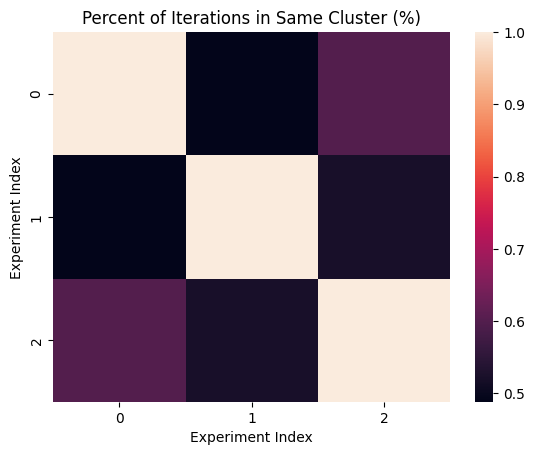

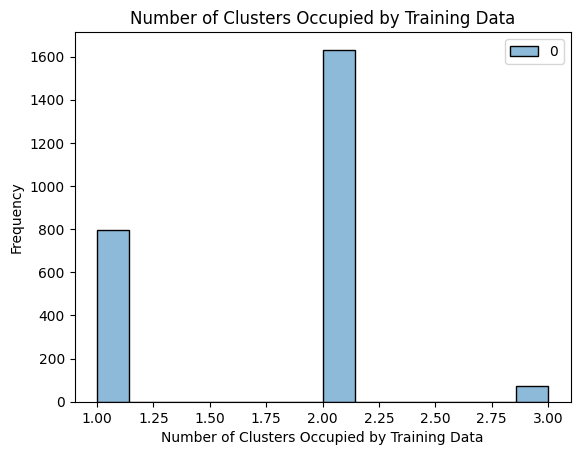

In [52]:
import itertools

cluster_draws = np.vstack(delta_exp).T
cluster_draws = cluster_draws[mcmc_use, :]
D = []
for i in range(setup.nclustmax):
    A = [
        np.where(cluster_draws[j, :] == i)[0]
        for j in range(cluster_draws.shape[0])
        if len(np.where(cluster_draws[j, :] == i)[0]) > 1
    ]
    B = [
        np.asarray(list(itertools.combinations(A[j], 2))) for j in range(len(A))
    ]
    D.append(np.concatenate(B, axis=0))
cluster_pairs = np.concatenate(D, axis=0)
co_cluster = np.zeros((nexp, nexp), dtype="int32")
for i in range(cluster_pairs.shape[0]):
    co_cluster[cluster_pairs[i, 0], cluster_pairs[i, 1]] = (
        co_cluster[cluster_pairs[i, 0], cluster_pairs[i, 1]] + 1
    )
    co_cluster[cluster_pairs[i, 1], cluster_pairs[i, 0]] = (
        co_cluster[cluster_pairs[i, 0], cluster_pairs[i, 1]] + 1
    )
co_cluster = co_cluster / cluster_draws.shape[0]
for i in range(nexp):
    co_cluster[i, i] = 1
ax = sns.heatmap(co_cluster, linewidths=0)
ax.set_xlabel("Experiment Index")
ax.set_ylabel("Experiment Index")
ax.set_title("Percent of Iterations in Same Cluster (%)")
plt.show()

num_clust = [
    len(np.unique(cluster_draws[i, :])) for i in range(cluster_draws.shape[0])
]
ax = sns.histplot(pd.DataFrame(num_clust))
ax.set_xlabel("Number of Clusters Occupied by Training Data")
ax.set_ylabel("Frequency")
ax.set_title("Number of Clusters Occupied by Training Data")
plt.show()